In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", palette="muted")


In [36]:
df = pd.read_csv("nyc_taxi_sample.csv")
print("Initial Shape:", df.shape)
print(df.head())

Initial Shape: (5000, 12)
   trip_id pickup_datetime dropoff_datetime  passenger_count  trip_distance  \
0        1      01-01-2022       01-01-2022                4           1.25   
1        2      01-01-2022       01-01-2022                4           1.21   
2        3      01-01-2022       01-01-2022                2           6.10   
3        4      01-01-2022       01-01-2022                3           5.63   
4        5      01-01-2022       01-01-2022                3           5.08   

     pickup_zone   dropoff_zone  fare_amount  tip_amount  total_amount  \
0          Bronx      Manhattan         3.48        0.22          3.70   
1          Bronx  Staten Island         3.19        0.22          3.41   
2          Bronx       Brooklyn        19.88        5.32         25.20   
3          Bronx         Queens        19.31        3.17         22.48   
4  Staten Island  Staten Island        15.75        2.61         18.36   

  payment_type  driver_id  
0  Credit Card        149 

In [37]:
##data cleaning part

In [38]:
df = df[(df['trip_distance'] > 0) &
        (df['fare_amount'] > 0) &
        (df['passenger_count'] > 0)]

In [39]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%d-%m-%Y', errors='coerce')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format='%d-%m-%Y', errors='coerce')

In [40]:
df['month'] = df['pickup_datetime'].dt.month_name()
df['weekday'] = df['pickup_datetime'].dt.day_name()

In [41]:
print(df.describe())

           trip_id             pickup_datetime            dropoff_datetime  \
count  5000.000000                        5000                        5000   
mean   2500.500000  2022-01-09 04:29:34.080000  2022-01-09 04:59:13.920000   
min       1.000000         2022-01-01 00:00:00         2022-01-01 00:00:00   
25%    1250.750000         2022-01-05 00:00:00         2022-01-05 00:00:00   
50%    2500.500000         2022-01-09 00:00:00         2022-01-09 00:00:00   
75%    3750.250000         2022-01-14 00:00:00         2022-01-14 00:00:00   
max    5000.000000         2022-01-18 00:00:00         2022-01-18 00:00:00   
std    1443.520003                         NaN                         NaN   

       passenger_count  trip_distance  fare_amount   tip_amount  total_amount  \
count      5000.000000    5000.000000  5000.000000  5000.000000   5000.000000   
mean          2.503600       7.628344    22.879818     4.065124     26.944942   
min           1.000000       0.500000     1.290000    

In [71]:
###EDA PART

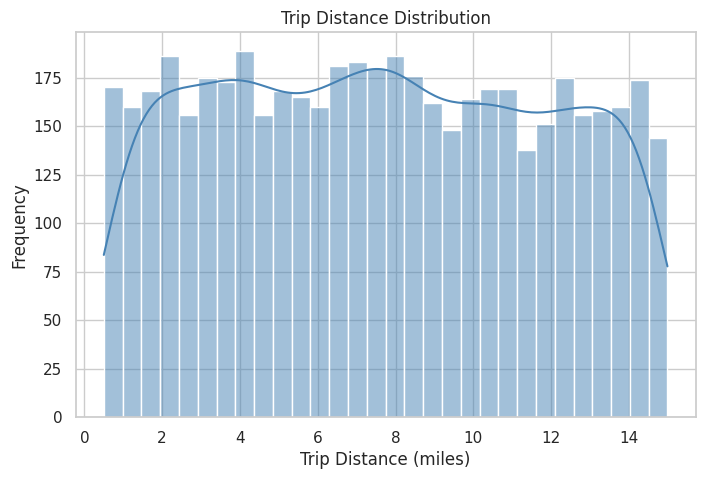

In [42]:
# ===============================
# 🧭 1️⃣ Trip Distance Distribution
# ===============================
plt.figure(figsize=(8,5))
sns.histplot(df['trip_distance'], bins=30, kde=True, color='steelblue')
plt.title("Trip Distance Distribution")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.show()

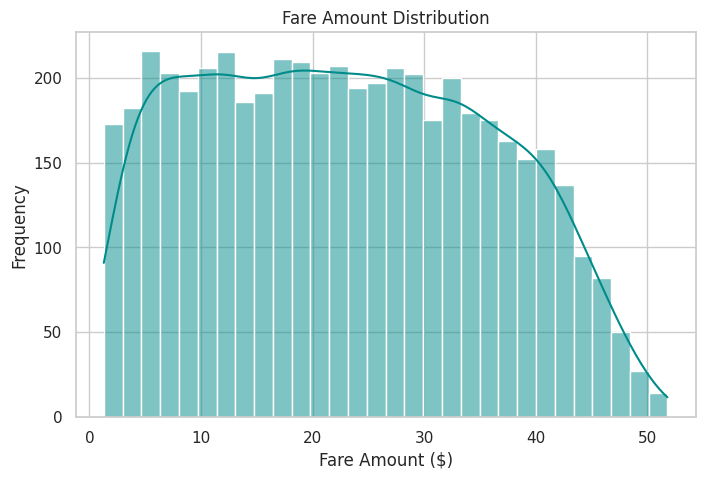

In [43]:
# ===============================
# 💰 2️⃣ Fare Amount Distribution
# ===============================
plt.figure(figsize=(8,5))
sns.histplot(df['fare_amount'], bins=30, kde=True, color='darkcyan')
plt.title("Fare Amount Distribution")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Frequency")
plt.show()

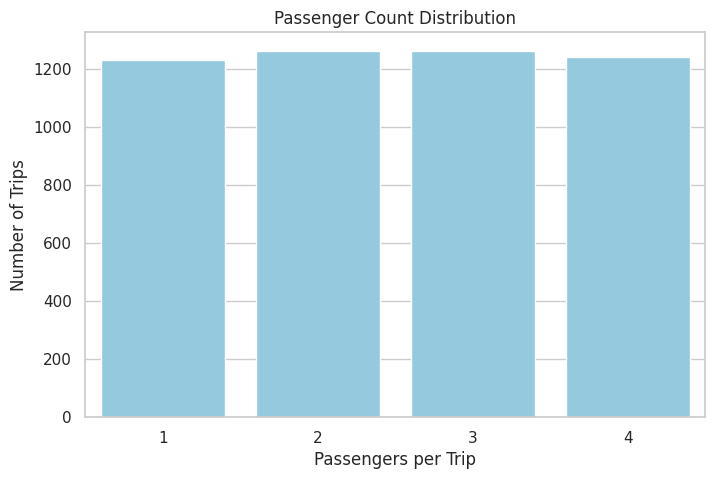

In [44]:
# ===============================
# 🚖 3️⃣ Passenger Count Distribution
# ===============================
plt.figure(figsize=(8,5))
sns.countplot(x='passenger_count', data=df, color='skyblue')
plt.title("Passenger Count Distribution")
plt.xlabel("Passengers per Trip")
plt.ylabel("Number of Trips")
plt.show()

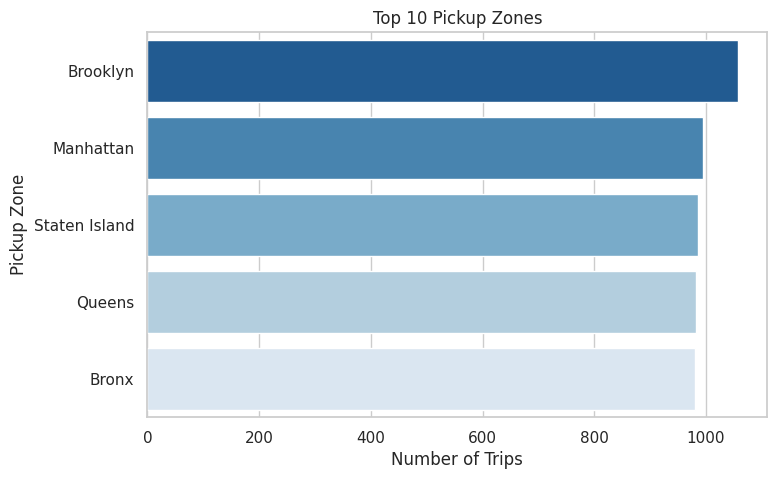

In [45]:
# ===============================
# 🌆 4️⃣ Most Common Pickup Zones
# ===============================
plt.figure(figsize=(8,5))
top_pickups = df['pickup_zone'].value_counts().nlargest(10)
sns.barplot(x=top_pickups.values, y=top_pickups.index, palette='Blues_r')
plt.title("Top 10 Pickup Zones")
plt.xlabel("Number of Trips")
plt.ylabel("Pickup Zone")
plt.show()

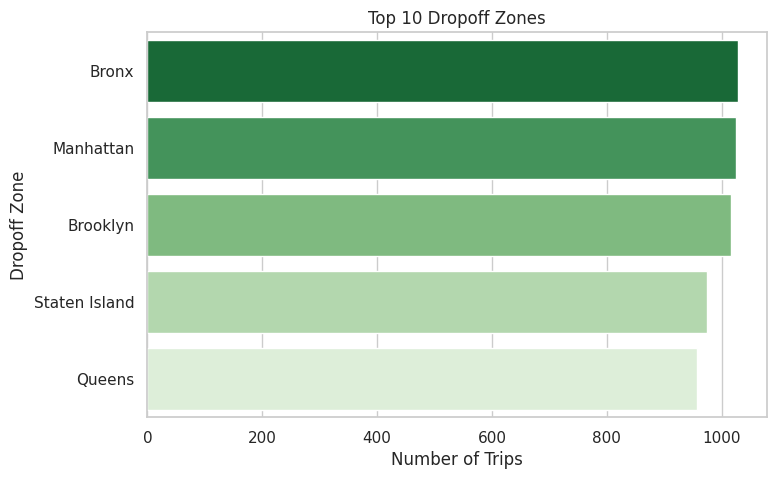

In [46]:
# ===============================
# 🏙 5️⃣ Most Common Dropoff Zones
# ===============================
plt.figure(figsize=(8,5))
top_dropoffs = df['dropoff_zone'].value_counts().nlargest(10)
sns.barplot(x=top_dropoffs.values, y=top_dropoffs.index, palette='Greens_r')
plt.title("Top 10 Dropoff Zones")
plt.xlabel("Number of Trips")
plt.ylabel("Dropoff Zone")
plt.show()

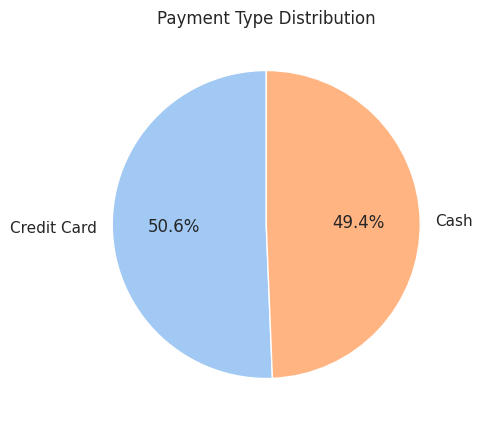

In [47]:
# ===============================
# 💳 6️⃣ Payment Type Breakdown
# ===============================
plt.figure(figsize=(6,5))
df['payment_type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Payment Type Distribution")
plt.ylabel("")
plt.show()


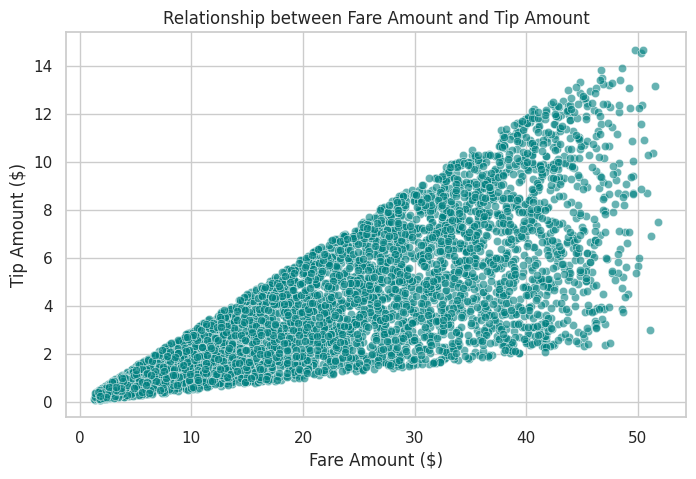

In [48]:
# ===============================
# 💵 7️⃣ Tip vs Fare Relationship
# ===============================
plt.figure(figsize=(8,5))
sns.scatterplot(x='fare_amount', y='tip_amount', data=df, alpha=0.6, color='teal')
plt.title("Relationship between Fare Amount and Tip Amount")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Tip Amount ($)")
plt.show()

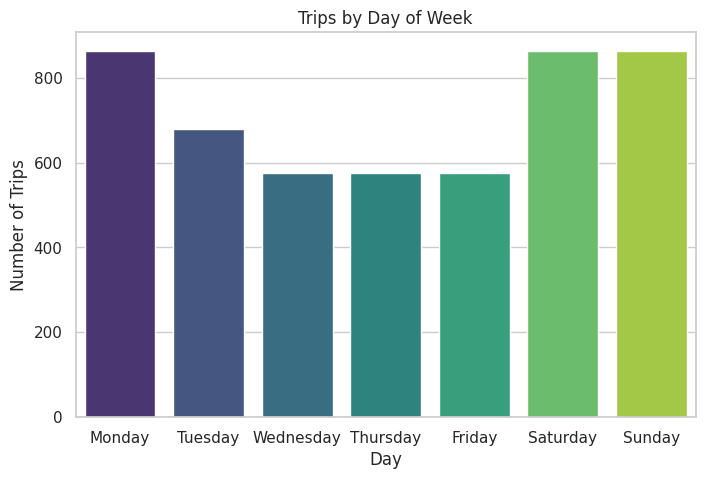

In [50]:
# ===============================
# 🗓 9️⃣ Weekday-wise Trip Count
# ===============================
weekday_trips = df['weekday'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.figure(figsize=(8,5))
sns.barplot(x=weekday_trips.index, y=weekday_trips.values, palette='viridis')
plt.title("Trips by Day of Week")
plt.xlabel("Day")
plt.ylabel("Number of Trips")
plt.show()

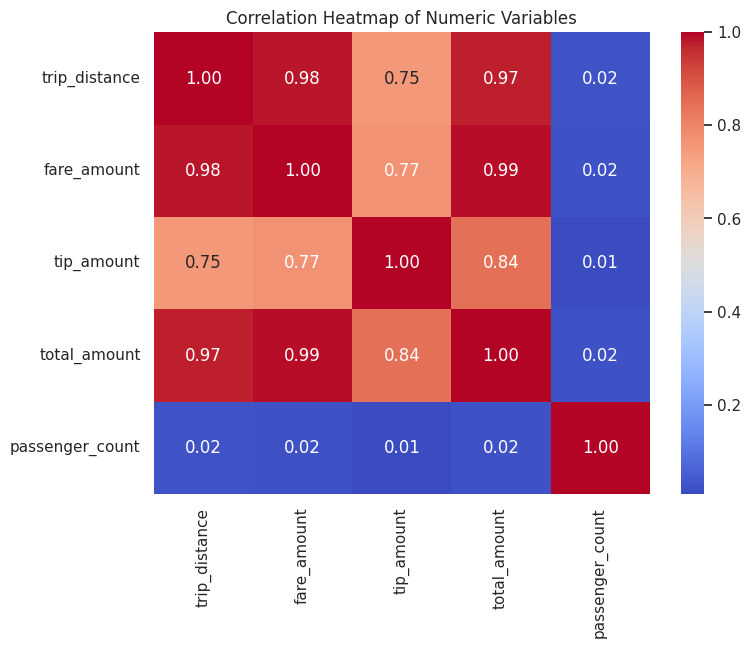

In [51]:
# ===============================
# 📊 🔟 Correlation Heatmap
# ===============================
plt.figure(figsize=(8,6))
sns.heatmap(df[['trip_distance','fare_amount','tip_amount','total_amount','passenger_count']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

In [52]:
##Feature Engineering

In [54]:
df = df.dropna(subset=['fare_amount', 'trip_distance'])

In [55]:
df.describe()

,trip_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,driver_id
count,5000.000000,5000,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,2022-01-09 04:29:34.080000,2022-01-09 04:59:13.920000,2.503600,7.628344,22.879818,4.065124,26.944942,148.906600
min,1.000000,2022-01-01 00:00:00,2022-01-01 00:00:00,1.000000,0.500000,1.290000,0.090000,1.410000,100.000000
25%,1250.750000,2022-01-05 00:00:00,2022-01-05 00:00:00,2.000000,4.057500,12.070000,1.670000,14.177500,124.000000
50%,2500.500000,2022-01-09 00:00:00,2022-01-09 00:00:00,3.000000,7.580000,22.460000,3.350000,26.245000,149.000000
75%,3750.250000,2022-01-14 00:00:00,2022-01-14 00:00:00,3.000000,11.162500,33.107500,5.910000,39.172500,174.000000
max,5000.000000,2022-01-18 00:00:00,2022-01-18 00:00:00,4.000000,14.990000,51.790000,14.690000,65.180000,199.000000
std,1443.520003,NaN,NaN,1.113119,4.147973,12.692867,2.948174,15.076339,29.079488


In [56]:
df = df[(df['fare_amount'] > 0) & (df['trip_distance'] > 0)]
df = df[df['fare_amount'] < 200]
df = df[df['trip_distance'] < 50]

In [57]:
categorical_cols = ['pickup_zone', 'dropoff_zone', 'payment_type', 'weekday', 'month']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [58]:
X = df_encoded.drop(['fare_amount', 'pickup_datetime', 'dropoff_datetime'], axis=1, errors='ignore')
y = df_encoded['fare_amount']

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (4000, 21)
Test shape: (1000, 21)


In [60]:
##my first model is linear regression

In [61]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [62]:
y_pred_lr = lr.predict(X_test)

In [64]:
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))

Linear Regression R²: 1.0


In [66]:
## second model is random forest and i am tuning it with optuna

In [69]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Define model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    preds = model.predict(X_test)

    # Compute RMSE manually (for older sklearn versions)
    mse = mean_squared_error(y_test, preds)
    rmse = sqrt(mse)

    return rmse

In [70]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2025-10-30 14:53:59,892] A new study created in memory with name: no-name-6e71f7ad-a8d7-4bd7-bb3c-d60d57e25ced
[I 2025-10-30 14:54:12,780] Trial 0 finished with value: 0.19874165217655193 and parameters: {'n_estimators': 488, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.19874165217655193.
[I 2025-10-30 14:54:20,666] Trial 1 finished with value: 0.20939885875436862 and parameters: {'n_estimators': 482, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.19874165217655193.
[I 2025-10-30 14:54:22,894] Trial 2 finished with value: 0.2090647371203851 and parameters: {'n_estimators': 125, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.19874165217655193.
[I 2025-10-30 14:54:26,618] Trial 3 finished with value: 0.2329203560749316 and parameters: {'n_estimators': 172, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with

In [72]:
print("Best Parameters:", study.best_params)
print("Best RMSE:", study.best_value)

Best Parameters: {'n_estimators': 488, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best RMSE: 0.19874165217655193


In [73]:
best_rf = RandomForestRegressor(**study.best_params, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=13, n_estimators=488, random_state=42)

In [74]:
y_pred_rf = best_rf.predict(X_test)

In [76]:
r2 = r2_score(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = sqrt(mse)
print(f"Optimized Random Forest R²: {r2:.4f}")
print(f"Optimized Random Forest RMSE: {rmse:.4f}")

Optimized Random Forest R²: 0.9998
Optimized Random Forest RMSE: 0.1987


In [78]:
##Trip Segmentation using K-Means Clustering
##After predicting fares, let’s cluster the trips to identify distinct travel behavior groups (short-distance vs long-distance, high-fare, etc.).

In [79]:
# Select features relevant for clustering
cluster_features = df[['trip_distance', 'total_amount', 'tip_amount', 'passenger_count']].dropna()

In [80]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_features)

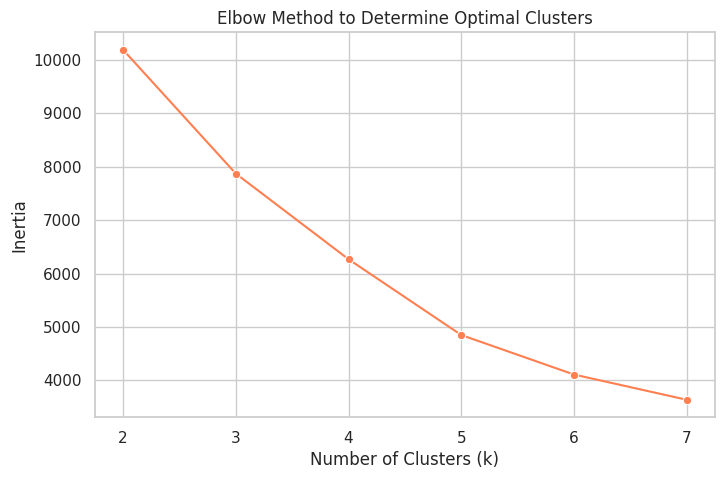

In [81]:
# Determine optimal k (elbow method)
inertia = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
sns.lineplot(x=range(2,8), y=inertia, marker='o', color='coral')
plt.title("Elbow Method to Determine Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [88]:
# Final K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_scaled)

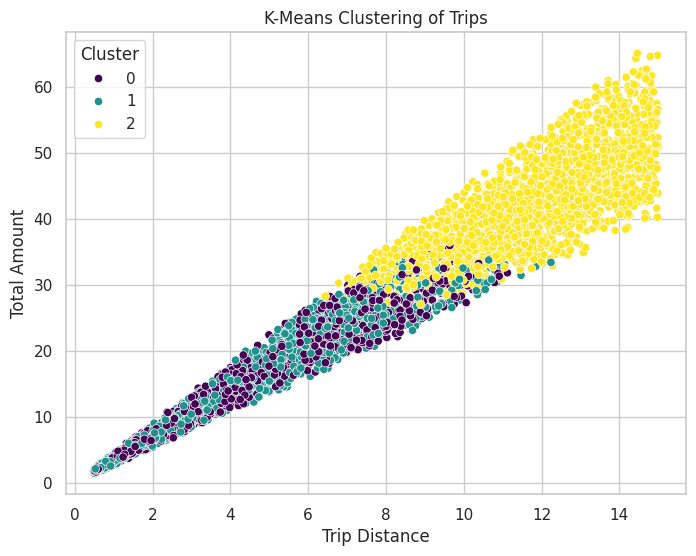

In [89]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['trip_distance'], y=df['total_amount'], hue=df['cluster'], palette='viridis')
plt.title("K-Means Clustering of Trips")
plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.legend(title='Cluster')
plt.show()

In [90]:
cluster_summary = df.groupby('Cluster')[['trip_distance', 'fare_amount', 'trip_duration']].mean().round(2)
print("\n🚀 Cluster Summary:\n", cluster_summary)

KeyError: 'Cluster'